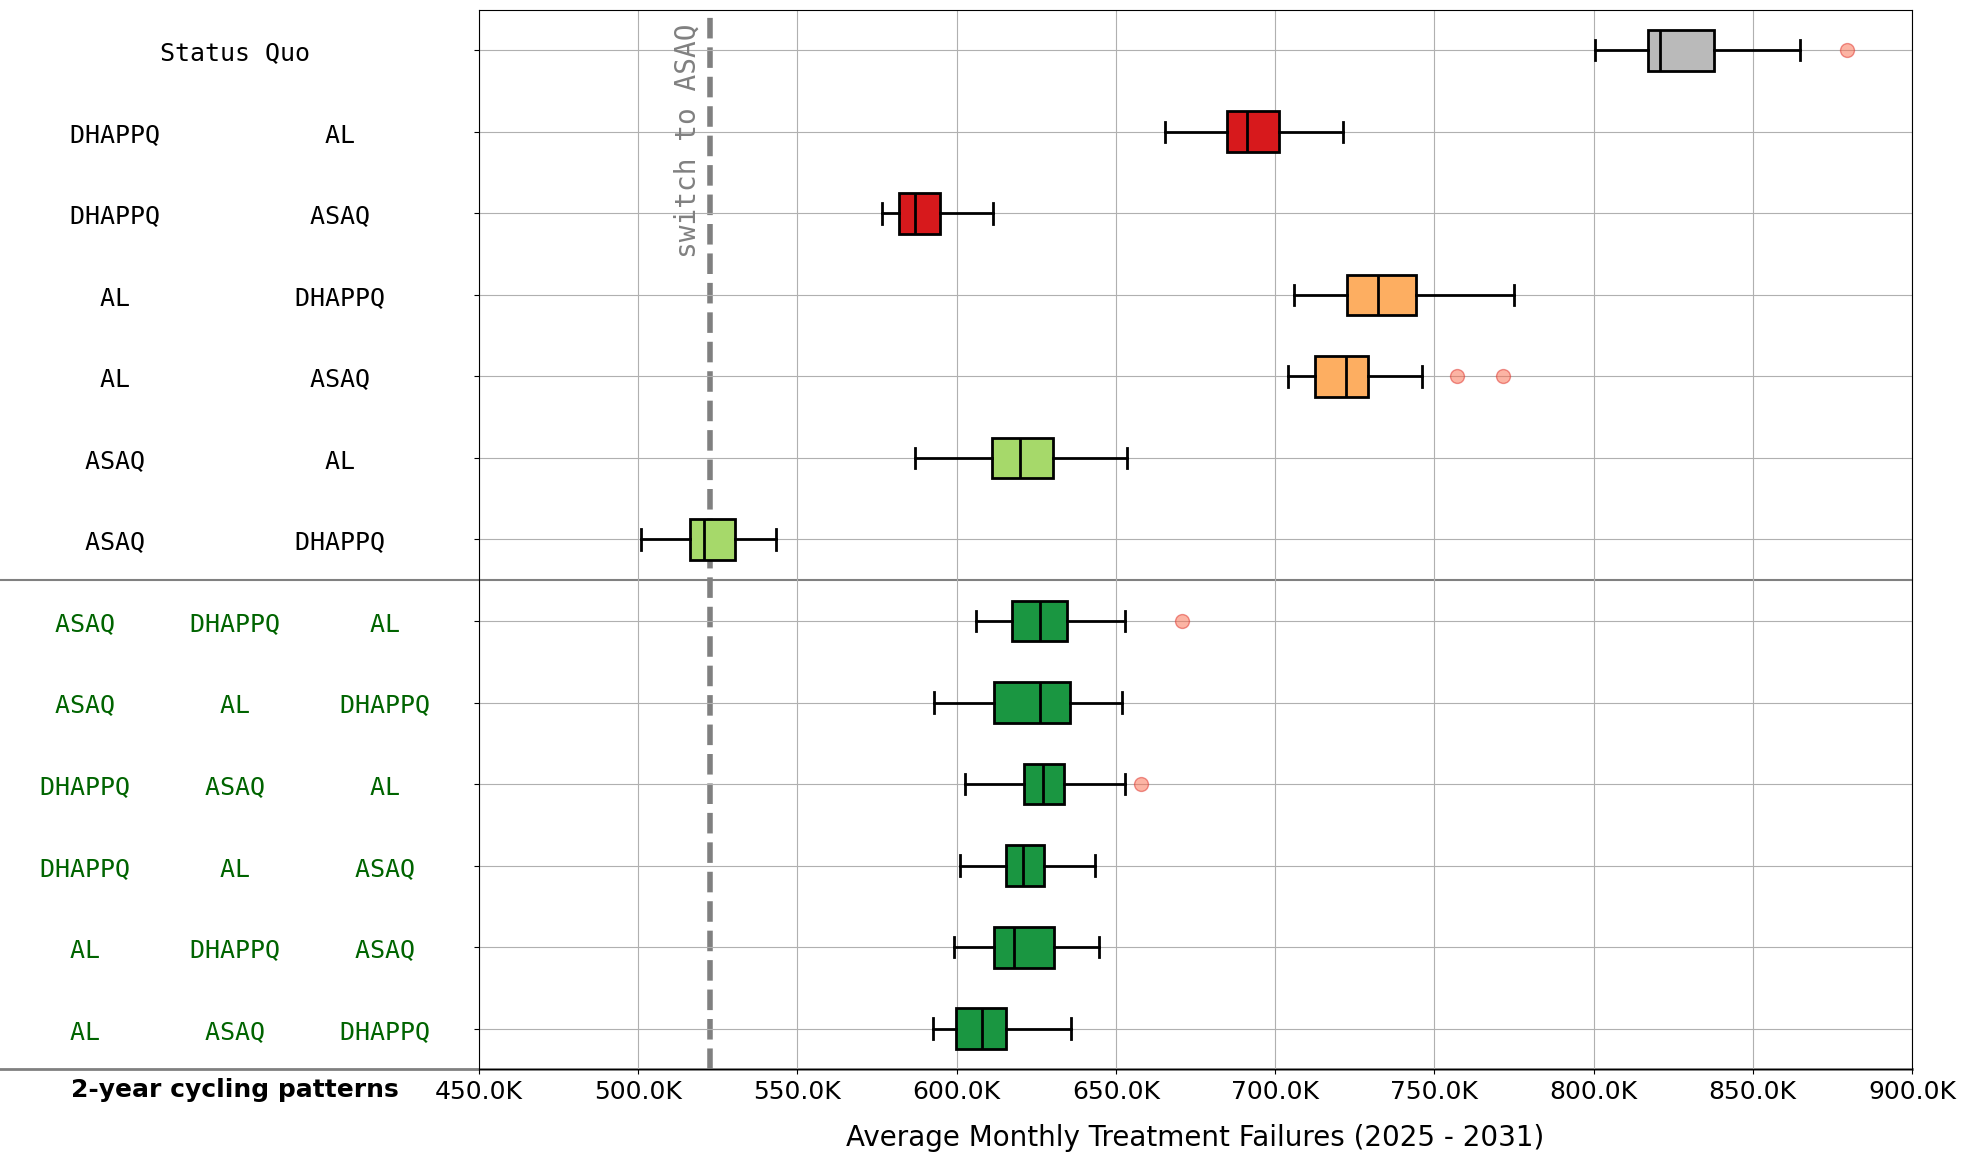

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter

# Custom formatter function for x-axis
def thousands_formatter(x, pos):
    return f'{int(x) / 1e3}K'

cycling_stategies = {
    "cycling_dhappq_al_2y": {"label": "DHAPPQ-AL", "color": "#d7191c", "position": 0},
    "cycling_dhappq_asaq_2y": {"label": "DHAPPQ-ASAQ", "color": "#d7191c", "position": 0},
    "cycling_al_dhappq_2y": {"label": "AL-DHAPPQ", "color": "#fdae61", "position": 0},
    "cycling_al_asaq_2y": {"label": "AL-ASAQ", "color": "#fdae61", "position": 0},
    "cycling_asaq_al_2y": {"label": "ASAQ-AL", "color": "#a6d96a", "position": 0},
    "cycling_asaq_dhappq_2y": {"label": "ASAQ-DHAPPQ", "color": "#a6d96a", "position": 0},
    "cycling_asaq_dhappq_al_2y": {"label": "ASAQ-DHAPPQ-AL", "color": "#1a9641", "position": 0},
    "cycling_asaq_al_dhappq_2y": {"label": "ASAQ-AL-DHAPPQ", "color": "#1a9641", "position": 0},
    "cycling_dhappq_asaq_al_2y": {"label": "DHAPPQ-ASAQ-AL", "color": "#1a9641", "position": 0},
    "cycling_dhappq_al_asaq_2y": {"label": "DHAPPQ-AL-ASAQ", "color": "#1a9641", "position": 0},
    "cycling_al_dhappq_asaq_2y": {"label": "AL-DHAPPQ-ASAQ", "color": "#1a9641", "position": 0},
    "cycling_al_asaq_dhappq_2y": {"label": "AL-ASAQ-DHAPPQ", "color": "#1a9641", "position": 0},
}

# Setting
corrected_scenario_mapping_dict = {"status_quo": {"label": "Status Quo", "color": "#bababa"}}
corrected_scenario_mapping_dict.update(cycling_stategies)

for i, key in enumerate(corrected_scenario_mapping_dict):
    corrected_scenario_mapping_dict[key]['position'] = -i

group_endings = ["cycling_asaq_dhappq_2y", "cycling_al_asaq_dhappq_2y"]

# Define total width (divisible by 6 for flexibility)
total_width = 30
col_width_3 = total_width // 3  # Width for each column in 3-column rows
col_width_2 = total_width // 2  # Width for each column in 3-column rows

# Extract labels from the dictionary, split by "-" and format them
y_ticks_dynamic = []
for key in corrected_scenario_mapping_dict:
    labels = corrected_scenario_mapping_dict[key]['label'].split('-')
    if len(labels) == 1:  # 1 column
        labels = [labels[0]]
        formatted_label = ''.join([f"{label:^{total_width}}" for label in labels])
    elif len(labels) == 2:  # 2 columns
        # labels.append(labels[0])  # Repeat the first label
        formatted_label = ''.join([f"{label:^{col_width_2}}" for label in labels])
    else:  # 3 columns
        formatted_label = ''.join([f"{label:^{col_width_3}}" for label in labels])
    y_ticks_dynamic.append(formatted_label)

# print(y_ticks_dynamic)
# for label in y_ticks_dynamic:
#     print(f"'{label}' length: {len(label)}")

# Load the dataset
data_path = './data/ntfs_6y.csv'
data_labeled = pd.read_csv(data_path)
data_labeled = data_labeled[(data_labeled["scenario"].isin(corrected_scenario_mapping_dict.keys())) & (data_labeled["year"] == 2031)]
data_labeled["total_treatmentfailures"] = data_labeled["total_treatmentfailures"] / (6 * 12)

data_labeled['position'] = data_labeled['scenario'].apply(lambda x: corrected_scenario_mapping_dict[x]['position'])

# Introduce variables for box width and spacing
box_width = 0.2  # Can be adjusted for narrower or wider boxes
spacing_multiplier = 0.4  # Adjust this to make boxplots closer or further apart
dynamic_positions = {scenario: details["position"] * spacing_multiplier for scenario, details in corrected_scenario_mapping_dict.items()}

# Calculate dynamic positions for dashed lines
adjusted_group_separators = [dynamic_positions[scenario] - 0.5 * spacing_multiplier for scenario in group_endings[:-1]]  # Adjust, exclude last

plt.rcdefaults()
plt.rcParams['font.size'] = 18
lw = 2
outlier_size = 10

# Create the plots with corrected positions
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 12), sharey=False, sharex=False)

for scenario, details in corrected_scenario_mapping_dict.items():
    scenario_data = data_labeled[(data_labeled['scenario'] == scenario) & (data_labeled['year'] == 2031)]['total_treatmentfailures']
    if not scenario_data.empty:
        ax.boxplot(scenario_data, positions=[dynamic_positions[scenario]], 
                   widths=box_width, vert=False, patch_artist=True,
                   boxprops=dict(facecolor=details['color'], color='black', linewidth=lw),
                   whiskerprops=dict(color='black', linewidth=lw),
                   capprops=dict(color='black', linewidth=lw),
                   medianprops=dict(color='black', linewidth=lw),
                   flierprops=dict(marker='o', markerfacecolor='#fb6a4a', markeredgecolor='#de2d26', alpha=0.5, markersize=outlier_size)
                   )
for separator in adjusted_group_separators:
    ax.axhline(y=separator, xmin=-1.2,
                   color='grey', linestyle='-',
                  zorder=0,
                     clip_on=False)
                   


# Set tick positions and custom labels
ax.set_yticks(list(dynamic_positions.values()))
ax.set_yticklabels(y_ticks_dynamic, fontname='monospace') 

# Adjust tick parameters for better padding
ax.tick_params(axis='y', pad=10)

# Change the color of 3-column labels to dark green
for i, tick in enumerate(ax.get_yticklabels()):
    if i > 6:  # First 3 rows are 3-column labels
        tick.set_color("darkgreen")

ax.set_xlim(450000, 900000)
min_y = min(dynamic_positions.values()) - 0.5 * spacing_multiplier
max_y = max(dynamic_positions.values()) + 0.5 * spacing_multiplier
ax.set_ylim(min_y, max_y)

ax.axhline(
    y=min_y,  # Line position
    xmin=-1.2,  # Extend into tick label region
    xmax=1,  # Span across the plot
    c="grey",  # Line color
    linewidth=2,  # Line thickness
    zorder=0,  # Ensure it renders behind the bars
    clip_on=False,  # Allow line to extend beyond axes
)

ax.axvline(
    x=522456,  # Line position
    c="grey",  # Line color
    linewidth=4,  # Line thickness
    linestyle = '--',
    zorder=0,  # Ensure it renders behind the bars
    clip_on=True,  # Allow line to extend beyond axes
)

ax.text(
    520000,  # Position on the x-axis
    -0.44,  # Position on the y-axis
    "switch to ASAQ",
    fontweight="normal",
    fontname='monospace',
    fontsize = 20,
    color="grey",
    rotation=90,
    va="center",
    ha="right",
)
# Add a general label at -0.5
ax.text(
    425000,  # Position on the x-axis
    min_y - 0.25 * spacing_multiplier ,  # Position on the y-axis
    "2-year cycling patterns",
    fontweight="bold",
    color="black",
    va="center",
    ha="right",
)


ax.set_xlabel('Average Monthly Treatment Failures (2025 - 2031)', fontsize=20, labelpad=15)
ax.xaxis.set_major_formatter(FuncFormatter(thousands_formatter))  # Apply the custom formatter
ax.grid(axis='both')

plt.tight_layout()
plt.savefig("figure_3.png", format="png", dpi=300)
plt.show()